<a href="https://colab.research.google.com/github/sharsulkar/H1B_LCA_outcome_prediction/blob/main/prototyping/notebooks/04_sh_train_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
%matplotlib inline

In [ ]:
#source and encode the output variable
Y=pd.read_excel('https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/LCA_Disclosure_Data_FY2020_Q2.xlsx',usecols=['CASE_STATUS'])
drop_row_index=Y[~Y.CASE_STATUS.isin(['Certified','Denied'])].index
Y.drop(index=drop_row_index, inplace=True)
Y.reset_index(inplace=True,drop=True)
Y.replace(['Certified','Denied'],[0,1],inplace=True)

In [127]:
#import features from saved file 
processed_df=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_train_q1q2processed.csv',index_col=0)
Y=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_train_q1q2_expected.csv',index_col=0)
processed_df.shape

(256141, 31)

In [130]:
Y.groupby('CASE_STATUS').size()

CASE_STATUS
0    254227
1      1914
dtype: int64

In [129]:
#Add the target column back to processed_df as it will be used in generate_train_val_batches function
drop_row_index=Y[~Y.CASE_STATUS.isin(['Certified','Denied'])].index
Y.drop(index=drop_row_index, inplace=True)
Y.reset_index(inplace=True,drop=True)
Y.replace(['Certified','Denied'],[0,1],inplace=True)
processed_df['CASE_STATUS']=Y

In [131]:
#algorithm to create mini batches where each batch has a equal distribution of both classes
class_count=2 #number of classes to predict
batch_size=250 #batch size of train+val dataset
val_size=0.2 #validation data % within batch

#collection of indexes for both classes from the entire training dataset
class_0_index=processed_df[processed_df.CASE_STATUS==0].index 
class_1_index=processed_df[processed_df.CASE_STATUS==1].index

In [132]:
def generate_train_val_batches(df,class_0_index,class_1_index,class_count,batch_size,val_size):
  #Generate batches to output training and val data 
  #randomly select indexes of batch size/class_count from the index collection for the entire dataset
  idx_0=random.sample(set(class_0_index.values),int(batch_size/class_count)) 
  idx_1=random.sample(set(class_1_index.values),int(batch_size/class_count))

  #split the indexes into train and val datasets within the selected batch
  split_value=int((batch_size*val_size)/class_count)
  idx_train=idx_0[split_value:]+idx_1[split_value:]
  idx_val=idx_0[:split_value]+idx_1[:split_value]

  #Generate the train and val datasets using the indexes selected in previous step
  X_train=df.loc[idx_train]
  X_val=df.loc[idx_val].reset_index(drop=True)
  y_val=X_val.pop('CASE_STATUS').astype(int)
  #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
  X_train=X_train.sample(frac=1).reset_index(drop=True)
  y_train=X_train.pop('CASE_STATUS').astype(int)

  return X_train, y_train, X_val, y_val

In [133]:
#skewness between classes - class 1 is only 0.7% of total
class_1_index.shape[0]*100/(class_0_index.shape[0]+class_1_index.shape[0])

0.7472446816401903

In [134]:
svc=SGDClassifier(loss='hinge')
logistic=SGDClassifier(loss='log')
adaboost=AdaBoostClassifier()
rfc=RandomForestClassifier()
kmeans=KMeans(n_clusters=2)
iforest=IsolationForest(contamination=0.01)
ocsvm=OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.001)

In [135]:
#loop over 
for _ in range(200):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  #train classifiers on batches
  for model in [svc,logistic,adaboost,rfc]:
    model.fit(X_train,y_train)
    #print(f1_score(y_true=y_val,y_pred=model.predict(X_val)))


In [ ]:
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0.2 #validation data % within batch
for _ in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  iforest.fit(X_train)
  y_pred=iforest.predict(X_val)
  y_pred=np.where(y_pred==1,0,y_pred)
  y_pred=np.where(y_pred==-1,1,y_pred)
  print(f1_score(y_true=y_val,y_pred=y_pred,average=None))

In [ ]:
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0.2 #validation data % within batch
for _ in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  ocsvm.fit(X_train)
  y_pred=ocsvm.predict(X_val)
  y_pred=np.where(y_pred==1,0,y_pred)
  y_pred=np.where(y_pred==-1,1,y_pred)
  print(f1_score(y_true=y_val,y_pred=y_pred,average=None))

In [ ]:
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0.2 #validation data % within batch
for _ in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  kmeans.fit(X_train,y_train)
  print(f1_score(y_true=y_val,y_pred=kmeans.predict(X_val),average=None))


In [12]:
X_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_test_q3processed.csv',index_col=0)
y_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_test_q3_expected.csv',index_col=0)
y_test.replace(['Certified','Denied'],[0,1],inplace=True)
y_test=y_test.astype(int)

In [136]:
print(f1_score(y_true=y_test,y_pred=svc.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=svc.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=rfc.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=rfc.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=logistic.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=logistic.predict(X_test),average=None))
#print(f1_score(y_true=y_test,y_pred=kmeans.predict(X_test),average='weighted'))
#print(f1_score(y_true=y_test,y_pred=kmeans.predict(X_test),average=None))

0.9720424115153293
[0.97805254 0.29022255]
0.9777416084432549
[0.98328825 0.34850142]
0.9772944613522053
[0.9828829  0.34331251]
0.9644745702020574
[0.97088619 0.2371065 ]


In [137]:
print(f1_score(y_true=y_train,y_pred=svc.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=adaboost.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=rfc.predict(X_train),average=None))
print(f1_score(y_true=y_train,y_pred=logistic.predict(X_train),average=None))
#print(f1_score(y_true=y_train,y_pred=kmeans.predict(X_train),average=None))

[0.98 0.98]
[1. 1.]
[1. 1.]
[0.98522167 0.98477157]


In [138]:
#plot_confusion_matrix(rfc,X_test,y_test)
confusion_matrix(y_true=y_test,y_pred=rfc.predict(X_test))

array([[175077,   6095],
       [     3,   1594]])

In [139]:
confusion_matrix(y_true=y_test,y_pred=svc.predict(X_test))
#plot_confusion_matrix(svc,X_test,y_test)

array([[173396,   7776],
       [     6,   1591]])

In [140]:
#plot_confusion_matrix(adaboost,X_test,y_test)
confusion_matrix(y_true=y_test,y_pred=adaboost.predict(X_test))

array([[175220,   5952],
       [     4,   1593]])

In [141]:
#plot_confusion_matrix(logistic,X_test,y_test)
confusion_matrix(y_true=y_test,y_pred=logistic.predict(X_test))

array([[170925,  10247],
       [     4,   1593]])

In [104]:
class_count=2 #number of classes to predict
batch_size=1250 #batch size of train+val dataset
val_size=0.2 #validation data % within batch

adaboost=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=100),n_estimators=200,learning_rate=0.1,random_state=10)

track_training_df=pd.DataFrame(columns=['iteration','training_f1_score','val_f1_score'])

for i in range(10):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  #train classifiers on batches
  adaboost.fit(X_train,y_train)
  track_training_df.loc[i]=[i,f1_score(y_true=y_train,y_pred=adaboost.predict(X_train),average='weighted'),f1_score(y_true=y_val,y_pred=adaboost.predict(X_val),average='weighted')]
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average=None))
confusion_matrix(y_true=y_test,y_pred=adaboost.predict(X_test))

0.6415316031222578
[0.64702754 0.01804393]


array([[86988, 94184],
       [  725,   872]])

In [ ]:
track_training_df

In [143]:
Y=processed_df.pop('CASE_STATUS')

In [144]:
class_count=2 #number of classes to predict
batch_size=1250 #batch size of train+val dataset
val_size=0.2 #validation data % within batch

adaboost=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=100),n_estimators=200,learning_rate=0.1,random_state=10)

track_training_df=pd.DataFrame(columns=['iteration','training_f1_score','val_f1_score'])

adaboost.fit(processed_df,Y)

print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average=None))
confusion_matrix(y_true=y_test,y_pred=adaboost.predict(X_test))

0.9985483778498753
[0.99926024 0.91779141]


array([[181005,    167],
       [   101,   1496]])

Text(0.5, 1.0, 'Decision Scores')

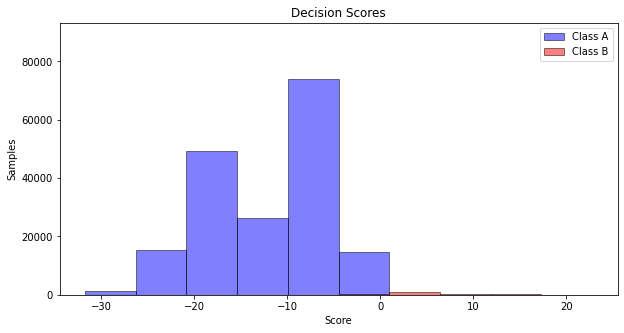

In [145]:
plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))
twoclass_output = adaboost.decision_function(X_test)
plot_range = (twoclass_output.min(), twoclass_output.max())

for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y_test['CASE_STATUS'] == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

In [146]:
from pickle import dump, load
dump(adaboost,open('/content/drive/MyDrive/saved_models/H1B_LCA_prediction/adaboost_full_training_data.pkl','wb'))

In [147]:
model=load(open('/content/drive/MyDrive/saved_models/H1B_LCA_prediction/adaboost_full_training_data.pkl','rb'))

In [148]:
confusion_matrix(y_true=y_test,y_pred=model.predict(X_test))

array([[181005,    167],
       [   101,   1496]])